<h1>Sentiment Analysis using Federated Learning </h1>
<h2>Building Sentiment Analysis using BiLSTM Model </h2>
<h3> Importing Necessary libararies </h3>


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re
import tensorflow as tf

<h4> Reading Data </h4>



In [ ]:
df_train = pd.read_csv("data (4).csv",names=["message","sentiment"],header=0)

In [ ]:
data = df_train[["message","sentiment"]]
data.head()

,message,sentiment
676,_xo they were so pretty and took like an hour ...,positive
8570,"is suffering from hayfever, is drowsy from too...",negative
5406,addict? Me? Okay I admit I need help BUT... ...,positive
1902,Fighting a migraine Medication is almost wor...,positive
6712,the puppy shall loose his um... manly parts to...,negative


In [ ]:
data = data.reset_index(drop=True)

<h4> Preprocessing text and Tokeninsation </h4>

In [ ]:
data['message'] = data['message'].apply(lambda x: x.lower())
# removing special chars
data['message'] = data['message'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#
data.head()

,message,sentiment
0,_xo they were so pretty and took like an hour ...,positive
1,is suffering from hayfever is drowsy from too ...,negative
2,addict me okay i admit i need help but i hav...,positive
3,fighting a migraine medication is almost wor...,positive
4,the puppy shall loose his um manly parts today...,negative


In [ ]:
data.sentiment.value_counts()

positive    3000
negative    3000
neutral     3000
Name: sentiment, dtype: int64

In [ ]:
max_fatures = 1000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['message'].values)
X = tokenizer.texts_to_sequences(data['message'].values)
X = pad_sequences(X)
X[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  76, 152,  18, 234,   7, 420,  38,  92,
        364,   2,  43,  32,   1,  43],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   9,  51,   9,  51,  41,  77,   7,   9, 551,
          2, 146,  23,   3, 806,  17]], dtype=int32)

<h4> BiLSTM Model building </h4>

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='Nadam',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 128)           128000    
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7200, 32) (7200, 3)
(1800, 32) (1800, 3)


In [ ]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
57/57 [==============================] - 8s 44ms/step - loss: 1.0715 - accuracy: 0.4251
Epoch 2/15
57/57 [==============================] - 4s 70ms/step - loss: 0.8278 - accuracy: 0.6268
Epoch 3/15
57/57 [==============================] - 3s 44ms/step - loss: 0.7059 - accuracy: 0.6939
Epoch 4/15
57/57 [==============================] - 3s 47ms/step - loss: 0.6470 - accuracy: 0.7251
Epoch 5/15
57/57 [==============================] - 4s 66ms/step - loss: 0.5947 - accuracy: 0.7563
Epoch 6/15
57/57 [==============================] - 4s 65ms/step - loss: 0.5176 - accuracy: 0.7969
Epoch 7/15
57/57 [==============================] - 3s 48ms/step - loss: 0.4171 - accuracy: 0.8469
Epoch 8/15
57/57 [==============================] - 3s 44ms/step - loss: 0.3304 - accuracy: 0.8926
Epoch 9/15
57/57 [==============================] - 3s 44ms/step - loss: 0.2652 - accuracy: 0.9186
Epoch 10/15
57/57 [==============================] - 3s 44ms/step - loss: 0.2256 - accuracy: 0.9300
Epoch 11/

<h4> Model Results </h4>

In [ ]:
Y_pred =np.argmax(model.predict(X_test), axis=-1)

df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))


57/57 [==============================] - 1s 7ms/step
confusion matrix [[330 250  24]
 [114 418  81]
 [ 33 195 355]]
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       604
           1       0.48      0.68      0.57       613
           2       0.77      0.61      0.68       583

    accuracy                           0.61      1800
   macro avg       0.65      0.61      0.62      1800
weighted avg       0.65      0.61      0.62      1800



# Federated Learning Setup

In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [ ]:
def create_clients(Xdata, label_list, num_clients=3, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''
    import random
    
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(Xdata, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [ ]:
class FLModel:
  def build(self):
    embed_dim = 128
    lstm_out = 196
    max_features = 1000
    noOfClasses = 3
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X_local.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.4))
    model.add(Dense(noOfClasses, activation='softmax'))

    return model


In [ ]:
clients = create_clients(X_train, Y_train, num_clients=5, initial='client')

In [ ]:
def sum_scaled_weights(scaled_weight_list):
      '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
      avg_grad = list()
      #get the average grad accross all client gradients
      for grad_list_tuple in zip(*scaled_weight_list):
          layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
          avg_grad.append(layer_mean)
          
      return avg_grad

def scale_model_weights(weight):
      '''function for scaling a models weights'''
      weight_final = []
      steps = len(weight)
      scalar  = 1/5

      for i in range(steps):
          weight_final.append(scalar * weight[i])
      return weight_final

In [ ]:
comms_round = 30
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr) 

#initialize global model
smlp_global = FLModel()
global_model = smlp_global.build()
global_acc = []
global_loss = 10  

noOfClasses = 3


#commence global training loop
while global_loss>=0.01 and comms_round!=0:
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    print("-----------------Workers Building Up------------------------------")
    for client in client_names:
        smlp_local = FLModel()
        local_model = smlp_local.build()
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        df_local = clients[client] #[(xdata,ydata)]
        X_local = []
        Y_local = []
        for i in df_local:
          X_local.append(i[0])
          Y_local.append(i[1])

        X_local = np.array(X_local)
        Y_local = np.array(Y_local)

        print(X_local.shape)
        print(Y_local.shape)

        local_model.fit(X_local,Y_local, epochs=10, verbose=0)
        scaled_weights = scale_model_weights(local_model.get_weights())
        local_weight_list.append(scaled_weights)

        lYpred =np.argmax(local_model.predict(X_local), axis=-1)

        lY_pred = []
        for i in lYpred:
          temp = []
          for j in range(noOfClasses):
            if j==i:
              temp.append(1)
            else:
              temp.append(0)
          lY_pred.append(temp)
        
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        llogits = model.predict(X_local)
        lloss = cce(Y_local, llogits)
        lacc =  accuracy_score(Y_local,lY_pred)
        print('comm_round: {} |  Client: {}| Local_acc: {:.3%} | local_loas: {}'.format(comms_round,client, lacc, lloss))
            
        #clear session to free memory after each communication round
        K.clear_session()
    print("-----------------Workers Building Done------------------------------")
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(local_weight_list)
    #update global model 
    
    global_model.set_weights(average_weights)
    #test global model and print out metrics after each communications round:
    Ypred =np.argmax(global_model.predict(X_train), axis=-1)

    Y_pred = []
    for i in Ypred:
      temp = []
      for j in range(noOfClasses):
        if j==i:
          temp.append(1)
        else:
          temp.append(0)
      Y_pred.append(temp)
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_train)
    global_loss = cce(Y_train, logits)
    acc =  accuracy_score(Y_train,Y_pred)
    global_acc.append(acc)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comms_round, acc, global_loss))
    print("--------------------------------------------------------------------------------------------")
    comms_round-=1

-----------------Workers Building Up------------------------------
(1440, 32)
(1440, 3)
45/45 [==============================] - 0s 7ms/step
comm_round: 30 |  Client: client_4| Local_acc: 35.694% | local_loas: 0.588005542755127
(1440, 32)
(1440, 3)
45/45 [==============================] - 1s 8ms/step
comm_round: 30 |  Client: client_3| Local_acc: 35.000% | local_loas: 0.5897355079650879
(1440, 32)
(1440, 3)
45/45 [==============================] - 1s 12ms/step
comm_round: 30 |  Client: client_1| Local_acc: 36.319% | local_loas: 0.5870653986930847
(1440, 32)
(1440, 3)
45/45 [==============================] - 1s 7ms/step
comm_round: 30 |  Client: client_5| Local_acc: 35.417% | local_loas: 0.5869148373603821
(1440, 32)
(1440, 3)
45/45 [==============================] - 1s 8ms/step
comm_round: 30 |  Client: client_2| Local_acc: 35.000% | local_loas: 0.5975772142410278
-----------------Workers Building Done------------------------------
225/225 [==============================] - 3s 10ms/ste

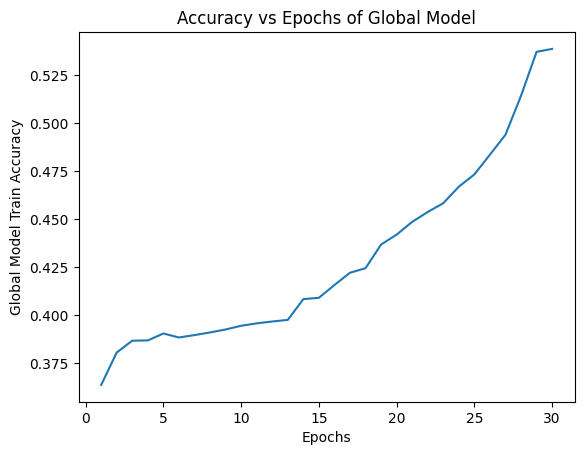

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,len(global_acc)+1)],global_acc)
plt.xlabel("Epochs")
plt.ylabel("Global Model Train Accuracy")
plt.title("Accuracy vs Epochs of Global Model")
plt.show()